In [1]:
%matplotlib inline
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

from aux import Generic
from disp import set_font_size
from lin_fit import fit_h, make_extended_predictor_matrix


EXPT = 'data_/CL_WHITE'
BASE = 'clean_0.csv'

NORMED_COLS = ['G4L', 'G4R']

DT = 0.1

# Load data

In [2]:
trials = []
data_u = {}  # unnormalized data
data_n = {}  # normalized data
d_mvng = {}  # dfs of moving times
d_odor = {}  # dfs of odor times

for fly in os.listdir(EXPT):
    fly_path = os.path.join(EXPT, fly)
    
    for trial in os.listdir(fly_path):
        trial_path = os.path.join(fly_path, trial)
        
        # load data
        data_o_ = pd.read_csv(os.path.join(trial_path, BASE))
        
        # store relevant columns
        data_u_ = pd.DataFrame()
        data_u_['Time'] = data_o_['TIME']
        data_u_['G4L'] = data_o_['G4L_GREEN'] / data_o_['G4L_RED']
        data_u_['G4R'] = data_o_['G4R_GREEN'] / data_o_['G4R_RED']
        data_u_['AngVel'] = data_o_['V_ANG']
        data_u_['AirAngVel'] = data_o_['W_AIR']
        data_u_['AirPos'] = data_o_['AIR']
        
        t = data_u_['Time']
        data_u_['WNMask'] = ((60 <= t) & (t < 120)) | ((180 <= t) & (t < 240))
        
        # normalize data
        data_n_ = data_u_.copy()
        data_n_[NORMED_COLS] -= data_n_[NORMED_COLS].mean()
        data_n_[NORMED_COLS] /= data_n_[NORMED_COLS].std()
        
        first_wn_mask = (60 <= t) & (t < 120)
        std_air_ang_vel = np.nanstd(data_n_['AirAngVel'][first_wn_mask])
        std_ang_vel = np.nanstd(data_n_['AngVel'][first_wn_mask])
        data_n_['AngVel'] = (std_air_ang_vel / std_ang_vel) * data_u_['AngVel']
        
        data_n_['G4D'] = data_n_['G4L'] - data_n_['G4R']
        
        # store all results
        data_u[trial] = data_u_
        data_n[trial] = data_n_
        
        trials.append(trial)

# Example w_air, angvel, G4D traces
White noise epoch shown in rectangle. Odor epoch indicated w/ hline.

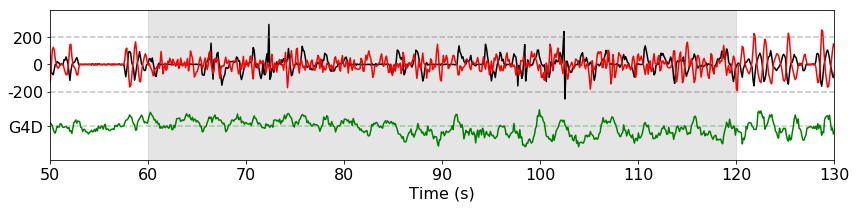

In [11]:
fig_size = (12, 3)
font_size = 16
trial = trials[0]
t_wdw = (50, 130)

fig, ax = plt.subplots(1, 1, figsize=fig_size, tight_layout=True)

t = data_n[trial]['Time']
ang_vel = data_n[trial]['AngVel']
air_ang_vel = data_n[trial]['AirAngVel']

# ang_vel and air_ang_vel
ax.plot(t, ang_vel, c='k')
ax.plot(t, air_ang_vel, c='r')

ax.axhline(-200, c='gray', ls='--', alpha=0.5)
ax.axhline(200, c='gray', ls='--', alpha=0.5)

offset = -450
scale = 50

g4d = data_n[trial]['G4D'].copy()
g4d -= g4d.mean()
g4d /= g4d.std()
g4d *= scale

ax.plot(t, g4d + offset, c='g')
ax.axhline(offset, c='g', ls='--', alpha=0.3)

ax.axvspan(60, 120, color='gray', alpha=0.2)
ax.axvspan(180, 240, color='gray', alpha=0.2)

ax.set_xlim(*t_wdw)
ax.set_ylim(-700, 400)

ax.set_yticks([offset, -200, 0, 200])
ax.set_yticklabels(['G4D', -200, 0, 200])

ax.set_xlabel('Time (s)')

set_font_size(ax, font_size)

In [4]:
# save for Ari
df_ari = pd.DataFrame(
    data={'TIME': t, 'ANG_VEL': ang_vel, 'AIR_ANG_VEL': air_ang_vel, 'G4D': g4d},
    columns=['TIME', 'ANG_VEL', 'AIR_ANG_VEL', 'G4D'])
df_ari.to_csv('rkp_thesis_fig_6/fig_6_a.csv', index=False)

# G4D-predicting filters fit w/ w_air or ang_vel

0.20865596524914432
0.14923549419214344
0.1749696355583783
0.14394866227329206
0.08660145686701869
0.40577665309116495
0.5620422206118034
0.288148173915863
0.32188903021980353
0.3050993861751262
0.46123840072435796
0.5820479440511543
0.3704262775924705
0.3774032168187976
0.3312894805092028


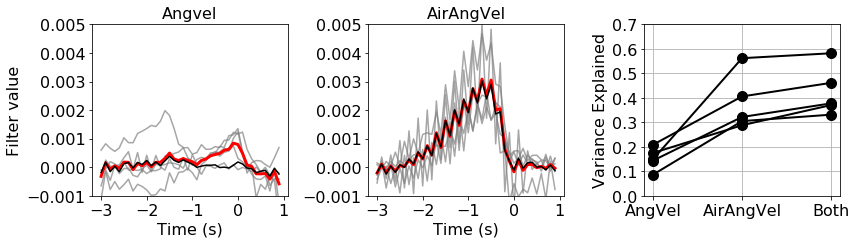

In [5]:
fig_size = (12, 3.5)
font_size = 16
wdw_d = (-30, 10)
filts = {}

# either AngVel or AirAngVel predicting G4D
for v in ['AngVel', 'AirAngVel']:
    
    filts_ = {}
    
    for trial in trials:
        
        xs = {v: data_n[trial][v]}
        y = data_n[trial]['G4D'].copy()
        y[~data_n[trial]['WNMask']] = np.nan
        
        hs, icpt, y_hat, r2 = fit_h(
            xs=xs, y=y, wdws_d={v: wdw_d}, order=[v], method='built-in', params={'model': LinearRegression})
        
        filts_[trial] = Generic(h=hs[v], y=y, y_hat=y_hat, r2=r2)
        
        print(r2)
    
    filts[v] = filts_

# AngVel and AirAngVel predicting G4D
filts_ = {}

for trial in trials:

    xs = {'AngVel': data_n[trial]['AngVel'], 'AirAngVel': data_n[trial]['AirAngVel']}
    y = data_n[trial]['G4D'].copy()
    y[~data_n[trial]['WNMask']] = np.nan

    hs, icpt, y_hat, r2 = fit_h(
        xs=xs, y=y,
        wdws_d={'AngVel': wdw_d, 'AirAngVel': wdw_d},
        order=['AngVel', 'AirAngVel'],
        method='built-in',
        params={'model': LinearRegression})

    filts_[trial] = Generic(hs=hs, y=y, y_hat=y_hat, r2=r2)

    print(r2)

filts['Full'] = filts_
    
fig, axs = plt.subplots(1, 3, figsize=fig_size, tight_layout=True)
t = (wdw_d[0]*DT) + (np.arange(len( filts['AngVel'][trials[0]].h ))*DT)

for trial in trials:
    axs[0].plot(t, filts['AngVel'][trial].h, color='gray', alpha=0.7)
    axs[1].plot(t, filts['AirAngVel'][trial].h, color='gray', alpha=0.7)

# AngVel or AirAngVel filters
axs[0].plot(t, np.mean([filts['AngVel'][trial].h for trial in trials], 0), c='r', lw=3)
axs[1].plot(t, np.mean([filts['AirAngVel'][trial].h for trial in trials], 0), c='r', lw=3)

# AngVel and AirAngVel filters
axs[0].plot(t, np.mean([filts['Full'][trial].hs['AngVel'] for trial in trials], 0), c='k', lw=1.5)
axs[1].plot(t, np.mean([filts['Full'][trial].hs['AirAngVel'] for trial in trials], 0), c='k', lw=1.5)

for ax in axs[:2]:
    ax.set_ylim(-0.001, 0.005)
    
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Filter value')

axs[1].set_xlabel('Time (s)')
axs[0].set_ylabel('Filter value')

axs[0].set_title('Angvel')
axs[1].set_title('AirAngVel')

# plot r2 changes
r2s = np.nan * np.zeros((3, 5))
r2s[0, :] = [filts['AngVel'][trial].r2 for trial in trials]
r2s[1, :] = [filts['AirAngVel'][trial].r2 for trial in trials]
r2s[2, :] = [filts['Full'][trial].r2 for trial in trials]

axs[2].plot(r2s, c='k', marker='o', lw=2, markersize=10)
axs[2].set_ylim(0, 0.7)
axs[2].set_xticks([0, 1, 2])
axs[2].set_xticklabels(['AngVel', 'AirAngVel', 'Both'])
axs[2].grid()
axs[2].set_ylabel('Variance Explained')

for ax in axs:
    set_font_size(ax, 16)

In [6]:
# save CSVs for ari
## indiv ang_vel filters
data = {'TRIAL_{}'.format(trial): filts['AngVel'][trial].h for trial in trials}
keys = list(data.keys())
data['TRIAL_MEAN'] = np.mean([filts['AngVel'][trial].h for trial in trials], 0)
data['TIME'] = t
pd.DataFrame(data=data, columns=(['TIME', 'TRIAL_MEAN'] + keys)).to_csv(
    'rkp_thesis_fig_6/fig_6_b_ang_vel_indiv.csv', index=False)

## indiv air_ang_vel filters
data = {'TRIAL_{}'.format(trial): filts['AirAngVel'][trial].h for trial in trials}
keys = list(data.keys())
data['TRIAL_MEAN'] = np.mean([filts['AirAngVel'][trial].h for trial in trials], 0)
data['TIME'] = t
pd.DataFrame(data=data, columns=(['TIME', 'TRIAL_MEAN'] + keys)).to_csv(
    'rkp_thesis_fig_6/fig_6_c_air_ang_vel_indiv.csv', index=False)

## ang_vel filters from full model
data = {'TRIAL_{}'.format(trial): filts['Full'][trial].hs['AngVel'] for trial in trials}
keys = list(data.keys())
data['TRIAL_MEAN'] = np.mean([filts['Full'][trial].hs['AngVel'] for trial in trials], 0)
data['TIME'] = t
pd.DataFrame(data=data, columns=(['TIME', 'TRIAL_MEAN'] + keys)).to_csv(
    'rkp_thesis_fig_6/fig_6_b_ang_vel_full.csv', index=False)

## air_ang_vel filters from full model
data = {'TRIAL_{}'.format(trial): filts['Full'][trial].hs['AirAngVel'] for trial in trials}
keys = list(data.keys())
data['TRIAL_MEAN'] = np.mean([filts['Full'][trial].hs['AirAngVel'] for trial in trials], 0)
data['TIME'] = t
pd.DataFrame(data=data, columns=(['TIME', 'TRIAL_MEAN'] + keys)).to_csv(
    'rkp_thesis_fig_6/fig_6_c_air_ang_vel_full.csv', index=False)

data = {
    'R2AngVel': [filts['AngVel'][trial].r2 for trial in trials],
    'R2AirAngVel': [filts['AirAngVel'][trial].r2 for trial in trials],
    'R2Full': [filts['Full'][trial].r2 for trial in trials]
}
pd.DataFrame(data=data, columns=['R2AngVel', 'R2AirAngVel', 'R2Full']).to_csv('rkp_thesis_fig_6/fig_6_d_r2.csv', index=False)

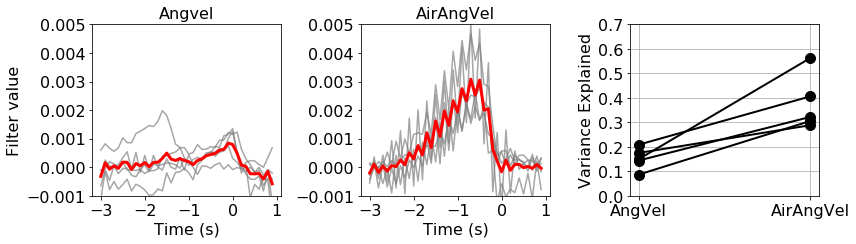

In [7]:
fig, axs = plt.subplots(1, 3, figsize=fig_size, tight_layout=True)
t = (wdw_d[0]*DT) + (np.arange(len( filts['AngVel'][trials[0]].h ))*DT)

for trial in trials:
    axs[0].plot(t, filts['AngVel'][trial].h, color='gray', alpha=0.7)
    axs[1].plot(t, filts['AirAngVel'][trial].h, color='gray', alpha=0.7)

# AngVel or AirAngVel filters
axs[0].plot(t, np.mean([filts['AngVel'][trial].h for trial in trials], 0), c='r', lw=3)
axs[1].plot(t, np.mean([filts['AirAngVel'][trial].h for trial in trials], 0), c='r', lw=3)

# AngVel and AirAngVel filters
#axs[0].plot(t, np.mean([filts['Full'][trial].hs['AngVel'] for trial in trials], 0), c='k', lw=1.5)
#axs[1].plot(t, np.mean([filts['Full'][trial].hs['AirAngVel'] for trial in trials], 0), c='k', lw=1.5)

for ax in axs[:2]:
    ax.set_ylim(-0.001, 0.005)
    
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Filter value')

axs[1].set_xlabel('Time (s)')
axs[0].set_ylabel('Filter value')

axs[0].set_title('Angvel')
axs[1].set_title('AirAngVel')

# plot r2 changes
r2s = np.nan * np.zeros((3, 5))
r2s[0, :] = [filts['AngVel'][trial].r2 for trial in trials]
r2s[1, :] = [filts['AirAngVel'][trial].r2 for trial in trials]
#r2s[2, :] = [filts['Full'][trial].r2 for trial in trials]

axs[2].plot(r2s, c='k', marker='o', lw=2, markersize=10)
axs[2].set_ylim(0, 0.7)
axs[2].set_xticks([0, 1])
axs[2].set_xticklabels(['AngVel', 'AirAngVel'])
axs[2].grid()
axs[2].set_ylabel('Variance Explained')

for ax in axs:
    set_font_size(ax, 16)

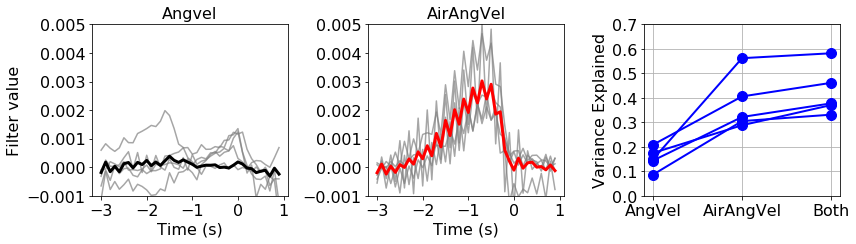

In [8]:
fig, axs = plt.subplots(1, 3, figsize=fig_size, tight_layout=True)
t = (wdw_d[0]*DT) + (np.arange(len( filts['AngVel'][trials[0]].h ))*DT)

for trial in trials:
    axs[0].plot(t, filts['AngVel'][trial].h, color='gray', alpha=0.7)
    axs[1].plot(t, filts['AirAngVel'][trial].h, color='gray', alpha=0.7)

# AngVel or AirAngVel filters
#axs[0].plot(t, np.mean([filts['AngVel'][trial].h for trial in trials], 0), c='r', lw=3)
#axs[1].plot(t, np.mean([filts['AirAngVel'][trial].h for trial in trials], 0), c='r', lw=3)

# AngVel and AirAngVel filters
axs[0].plot(t, np.mean([filts['Full'][trial].hs['AngVel'] for trial in trials], 0), c='k', lw=3)
axs[1].plot(t, np.mean([filts['Full'][trial].hs['AirAngVel'] for trial in trials], 0), c='r', lw=3)

for ax in axs[:2]:
    ax.set_ylim(-0.001, 0.005)
    
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Filter value')

axs[1].set_xlabel('Time (s)')
axs[0].set_ylabel('Filter value')

axs[0].set_title('Angvel')
axs[1].set_title('AirAngVel')

# plot r2 changes
r2s = np.nan * np.zeros((3, 5))
r2s[0, :] = [filts['AngVel'][trial].r2 for trial in trials]
r2s[1, :] = [filts['AirAngVel'][trial].r2 for trial in trials]
r2s[2, :] = [filts['Full'][trial].r2 for trial in trials]

axs[2].plot(r2s, c='b', marker='o', lw=2, markersize=10)
axs[2].set_ylim(0, 0.7)
axs[2].set_xticks([0, 1, 2])
axs[2].set_xticklabels(['AngVel', 'AirAngVel', 'Both'])
axs[2].grid()
axs[2].set_ylabel('Variance Explained')

for ax in axs:
    set_font_size(ax, 16)

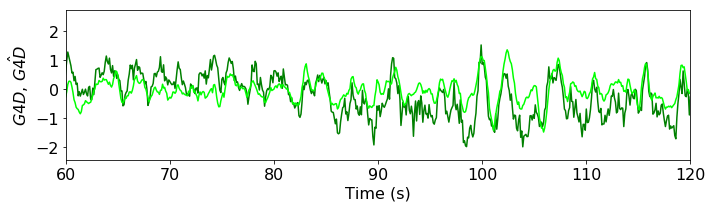

In [9]:
fig_size = (10, 3)
font_size = 16
trial = trials[0]
t_wdw = (60, 120)

t = data_n[trial]['Time']
g4d = data_n[trial]['G4D']
g4d_hat = filts['AirAngVel'][trial].y_hat

fig, ax = plt.subplots(1, 1, figsize=fig_size, tight_layout=True)
ax.plot(t, g4d, c='g')
ax.plot(t, g4d_hat, c=(0, 1, 0))

ax.set_xlim(t_wdw)

ax.set_xlabel('Time (s)')
ax.set_ylabel('$G4D$, $\hat{G4D}$')

set_font_size(ax, font_size)

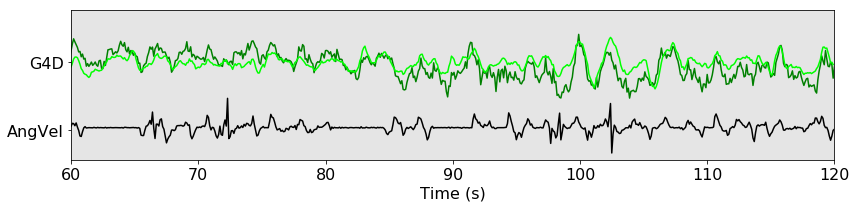

In [14]:
fig_size = (12, 3)
font_size = 16
trial = trials[0]
t_wdw = (60, 120)

t = data_n[trial]['Time']
g4d = data_n[trial]['G4D']
g4d_hat = filts['AirAngVel'][trial].y_hat

fig, ax = plt.subplots(1, 1, figsize=fig_size, tight_layout=True)
ax.plot(t, g4d, c='g')
ax.plot(t, g4d_hat, c=(0, 1, 0))

ang_vel = data_n[trial]['AngVel'].copy()
ang_vel -= ang_vel.min()
ang_vel *= (3)/ang_vel.max()

ax.plot(t, ang_vel - 5, c='k')
ax.axvspan(60, 120, color='gray', alpha=0.2)

ax.set_xlim(t_wdw)

ax.set_yticks([-3.75, 0])

ax.set_yticklabels(['AngVel', 'G4D'])

ax.set_xlabel('Time (s)')

set_font_size(ax, font_size)

In [15]:
data = {'TIME': t, 'G4D': g4d, 'G4D_PREDICTION': g4d_hat, 'ANG_VEL': data_n[trial]['AngVel'].copy()}
pd.DataFrame(data=data, columns=['TIME', 'G4D', 'G4D_PREDICTION', 'ANG_VEL']).to_csv(
    'rkp_thesis_fig_6/fig_6_e.csv', index=False)